In [6]:
import pandas as pd
import os
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [7]:
# مسیر فایل دیتا را تنظیم کن (در صورت نیاز تغییر بده)
# Set the file path for the dataset (modify if needed)
file_path = os.path.join(os.getcwd(), "pima_cleaned.csv")

# خواندن دیتاست
# Load the dataset
df = pd.read_csv(file_path)

# حذف ستون Outcome برای محاسبه فاصله بین ویژگی‌ها
# Remove the Outcome column to calculate distance between features
features = df.drop(columns=["Outcome"])

# محاسبه فاصله اقلیدسی بین نمونه‌ها
# Compute Euclidean distance between samples
euclidean_distances = pdist(features, metric='euclidean')

# تبدیل به ماتریس فاصله برای نمایش بهتر
# Convert to a distance matrix for better visualization
distance_matrix = squareform(euclidean_distances)

# نمایش ابعاد ماتریس فاصله
# Display the shape of the distance matrix
print("✅ محاسبه فاصله اقلیدسی انجام شد! شکل ماتریس فاصله:", distance_matrix.shape)

✅ محاسبه فاصله اقلیدسی انجام شد! شکل ماتریس فاصله: (768, 768)


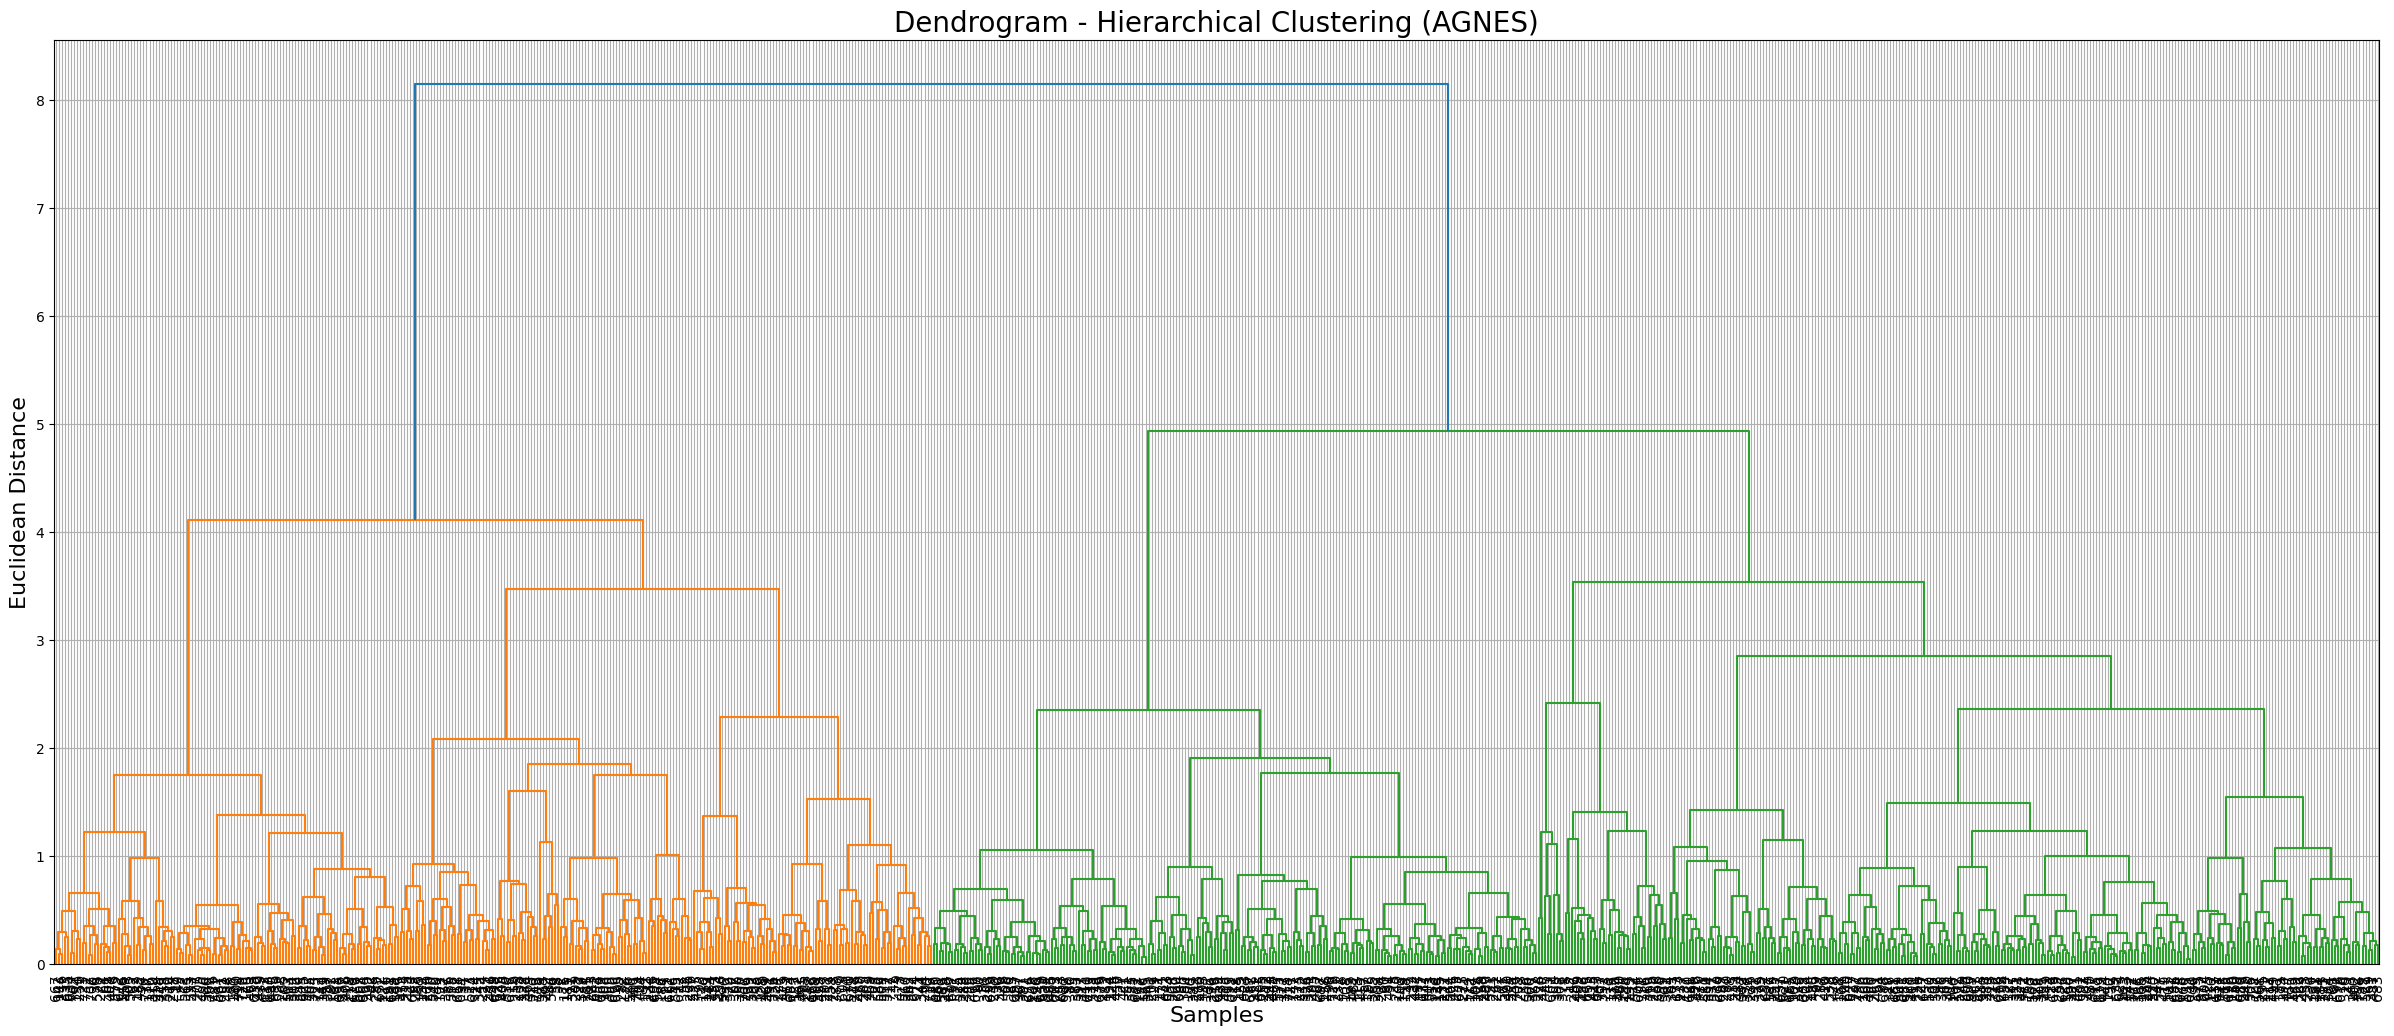

✅ دندروگرام رسم شد! حالا تعداد بهینه‌ی خوشه‌ها را مشخص می‌کنیم.


In [8]:
# اجرای خوشه‌بندی سلسله‌مراتبی (AGNES) با روش پیوندward
# Perform Hierarchical Clustering (AGNES) using Ward’s linkage
linkage_matrix = sch.linkage(euclidean_distances, method='ward')

# رسم دندروگرام برای نمایش سلسله‌مراتب خوشه‌بندی
# Plot the dendrogram to visualize clustering hierarchy
plt.figure(figsize=(30, 12))
plt.title("Dendrogram - Hierarchical Clustering (AGNES)", fontsize=20)
plt.xlabel("Samples", fontsize=16)
plt.ylabel("Euclidean Distance", fontsize=16)
sch.dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=10)
plt.grid(True)
plt.show()

print("✅ دندروگرام رسم شد! حالا تعداد بهینه‌ی خوشه‌ها را مشخص می‌کنیم.")
